In [49]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import graph_tool.all as gt

from matplotlib.colors import to_rgba


## Constants

In [50]:
category_colors = {
    "Insecta": "#424242",        # Dark Grey
    "Plantae": "#7FB800",        # Yellow-Green
    "Aves": "#00BFFF",           # Cyan/Sky Blue
    "Arachnida": "#C2002E",      # Deep Red
    "Actinopterygii": "#00A877", # Teal/Green
    "Mammalia": "#0088FE",       # Blue
    "Animalia": "#FF9900",       # Orange
    "Reptilia": "#008040",       # Dark Green
    "Amphibia": "#ADFF2F",       # Light Lime
    "Mollusca": "#FF99FF",       # Pink
    "Fungi": "#CC99FF"           # Light Purple
}

## Functions

### Plot Largest Components

In [51]:
def plot_top_largest_components(G, num_components=20):
    data = []
    for i, nodes in enumerate(nx.weakly_connected_components(G)):
        n_nodes = len(nodes)
        
        # Calculate degrees
        in_degrees = [d for n, d in G.in_degree(nodes)]
        out_degrees = [d for n, d in G.out_degree(nodes)]
        
        data.append({
            "ID": i + 1,
            "Nodes": n_nodes,
            "Log10 Nodes": np.log10(n_nodes),
            "Avg In-Degree": np.mean(in_degrees),
            "Avg Out-Degree": np.mean(out_degrees)
        })

    # Sorting list based on number of nodes (descending)
    data.sort(key=lambda x: x["Nodes"], reverse=True)
    data = data[:num_components]  # Keep only top components

    df = pd.DataFrame(data)

    # Plotting with Log Axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    x = np.arange(len(df))
    width = 0.25

    # Primary Axis: Node Count (Log Scale)
    bars1 = ax1.bar(x - width, df["Nodes"], width, label="Node Count (Log Scale)", color='#1f77b4')
    ax1.set_yscale('log')  # <--- This applies the log scale
    ax1.set_xlabel("Component ID")
    ax1.set_ylabel("Number of Nodes (Log Scale)", color='#1f77b4', fontsize=12)
    ax1.tick_params(axis='y', labelcolor='#1f77b4')
    ax1.set_xticks(x)
    ax1.set_xticklabels(df["ID"])

    # Secondary Axis: Average Degrees
    ax2 = ax1.twinx()
    bars2 = ax2.bar(x, df["Avg In-Degree"], width, label="Avg In-Degree", color='#ff7f0e')
    bars3 = ax2.bar(x + width, df["Avg Out-Degree"], width, label="Avg Out-Degree", color='#2ca02c')
    ax2.set_ylabel("Average Degree", color='black', fontsize=12)

    # Legend
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.title(f"Top {num_components} Components: Log(Size) vs. Average Degree")
    plt.tight_layout()
    plt.show()

### Plot Degree By Animal

In [52]:
def get_dataframe_top_degree_by_animal(graph, top_n=20, degree_type='in'):
    
    if degree_type == 'in':
        degree_list = list(graph.in_degree()) 
    else:
        degree_list = list(graph.out_degree())
    
    # Sort descending and ensure top_n isn't larger than the graph size
    top_n = max(min(top_n, len(degree_list)), 1)
    top = sorted(degree_list, key=lambda x: x[1], reverse=True)[:top_n]
    
    data = []
    bar_colors = []
    
    for node_id, degree in top:
        # Get Attributes
        name = graph.nodes[node_id].get('common_name', str(node_id))
        cat = graph.nodes[node_id].get('category', 'Unknown')
        
        # Get Color (Default to Light Grey if category not found)
        # Ensure 'category_colors' is defined in your global scope
        color = category_colors.get(cat, '#d3d3d3')
        
        # --- UPDATE HERE: Added 'Node ID' ---
        data.append({
            'Node ID': node_id, 
            'Name': name, 
            'Degree': degree, 
            'Category': cat
        })
        bar_colors.append(color)
        
    return pd.DataFrame(data), bar_colors

In [53]:
def plot_top_degree_comparison(graph, top_n=20):
    # Get the data
    df_in, colors_in = get_dataframe_top_degree_by_animal(graph, top_n, 'in')
    df_out, colors_out = get_dataframe_top_degree_by_animal(graph, top_n, 'out')

    print(df_in.head(3))
    print(df_out.head(3))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7)) # Slightly wider figure to fit legend

    # Plot In-Degree
    ax1.bar(df_in['Name'], df_in['Degree'], color=colors_in)
    ax1.set_title(f'Top {top_n} In-Degree (Preys)')
    ax1.set_ylabel('In-Degree')
    ax1.tick_params(axis='x', rotation=90)

    # Plot Out-Degree
    ax2.bar(df_out['Name'], df_out['Degree'], color=colors_out)
    ax2.set_title(f'Top {top_n} Out-Degree (Predators)')
    ax2.set_ylabel('Out-Degree')
    ax2.tick_params(axis='x', rotation=90)

    # Custom Legend
    patches = [mpatches.Patch(color=color, label=label) for label, color in category_colors.items()]
    fig.legend(handles=patches, 
            loc='center left', 
            bbox_to_anchor=(1, 0.5), 
            title="Category")

    # Plots extend to x=0.90 to leave the remaining 10% for the legend
    plt.tight_layout(rect=[0, 0, 0.90, 1])

    plt.show()

### Extract neighborhood graph

In [54]:
def extract_neighborhood_subgraph(df, graph, degree_type='in'):
    
    # Get the list of 'core' nodes from the DataFrame
    core_nodes = set(df['Node ID'].tolist())
    
    # All nodes we want to keep
    nodes_to_keep = set(core_nodes)
    
    # Find neighbors based on direction
    for node in core_nodes:
        if node in graph:
            if degree_type == 'in':
                # (Predecessors)
                neighbors = graph.predecessors(node)
            else:
                # (Successors)
                neighbors = graph.successors(node)
            
            # Add neighbors to the set
            nodes_to_keep.update(neighbors)
    
    # Create the subgraph
    sub_G = graph.subgraph(nodes_to_keep).copy()
    
    return sub_G

### Plot subnetwork

In [55]:
def plot_subnetwork(nx_graph, category_colors_dict, degree_type='in'):
    
    g = gt.Graph(directed=True)
    
    # Property Maps
    v_color = g.new_vertex_property("vector<double>")
    v_size = g.new_vertex_property("double")
    
    # Degree Calculation
    if degree_type == 'in':
        degree_map = dict(nx_graph.in_degree())
    else:
        degree_map = dict(nx_graph.out_degree())
    max_deg_val = max(degree_map.values()) if degree_map else 1
    
    nx_id_to_gt_node = {}
    
    # Add Nodes
    for node_id, data in nx_graph.nodes(data=True):
        v = g.add_vertex()
        nx_id_to_gt_node[node_id] = v
        
        # Color
        cat = data.get('category', 'Unknown')
        hex_color = category_colors_dict.get(cat, '#d3d3d3')
        v_color[v] = to_rgba(hex_color) 
        
        # Size
        v_size[v] = 20
        
    # Add Edges
    for source, target in nx_graph.edges():
        if source in nx_id_to_gt_node and target in nx_id_to_gt_node:
            g.add_edge(nx_id_to_gt_node[source], nx_id_to_gt_node[target])
            
    # Layout
    pos = gt.sfdp_layout(g, K=0.5)
    
    # Draw
    gt.graph_draw(
        g, 
        pos=pos, 
        vertex_font_size=10,
        vertex_fill_color=v_color,
        vertex_size=15,
        edge_pen_width=0.8,
        edge_end_marker="arrow",
        edge_marker_size=8,
        output_size=(600, 600),
        fit_view=True,
        bg_color=[1,1,1,1]
    )

### Plot betweeness by animal

In [65]:
def get_top_betweenness_df(G, top_n=20):
    
    # Calculate Betweenness Centrality
    centrality_scores = nx.betweenness_centrality(G)
    
    # Sort the dictionary by score (descending)
    sorted_nodes = sorted(centrality_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    
    # Build the data list
    data = []
    for node_id, score in sorted_nodes:
        
        # Get attributes
        name = G.nodes[node_id].get('common_name', str(node_id))
        cat = G.nodes[node_id].get('category', 'Unknown')
        
        data.append({
            'Node ID': node_id,
            'Name': name,
            'Centrality': score,
            'Category': cat
        })
        
    return pd.DataFrame(data)

In [67]:

def plot_betweenness_by_animal(G, top_n = 20):
    
    # Get the betweenness centrality by animal
    df = get_top_betweenness_df(G, top_n)

    plt.figure(figsize=(12, 6))
    
    # Map Colors
    # Create a list of colors corresponding to the rows in the DF
    bar_colors = [category_colors.get(cat, '#d3d3d3') for cat in df['Category']]
    
    # Draw Bars
    bars = plt.bar(df['Name'], df['Centrality'], color=bar_colors)
    
    # Formatting
    plt.title(f"Top {len(df)} Species by Betweenness Centrality ")
    plt.ylabel("Betweenness Centrality")
    plt.xlabel("Name")
    plt.xticks(rotation=45, ha='right') # Rotate names for readability
    
    # Custom Legend
    unique_categories = df['Category'].unique()
    legend_patches = [
        mpatches.Patch(color=category_colors.get(c, '#d3d3d3'), label=c) 
        for c in unique_categories
    ]
    
    # Place legend outside to the right
    plt.legend(handles=legend_patches, title="Category", bbox_to_anchor=(1.05, 1), loc='center left')
    
    plt.tight_layout()
    plt.show()

### Plot network motifs

In [58]:
def get_network_motifs_dataframe(G):
    # Calculate the Triadic Census
    census = nx.triadic_census(G)
    
    # Define the Mapping (Code and Biological Meaning)
    motif_names = {
        '021C': 'Food Chain', # (A->B->C)
        '030T': 'Intraguild Predation', # (A->B->C & A->C)
        '021U': 'Exploitative Competition', # (B->A<-C)
        '021D': 'Apparent Competition', # (B<-A->C)
        '201':  'Cycle' # (A->B->C->A)
    }
    
    # Filter and Format Data
    data = []
    for code, count in census.items():
        if code in motif_names:
            data.append({
                'Motif': motif_names[code],
                'Count': count,
                'Code': code
            })
            
    df = pd.DataFrame(data).sort_values('Count', ascending=False)
    return df
    

In [59]:
def plot_network_motifs(G):
    
    df = get_network_motifs_dataframe(G)

    # Colors for bars
    colors = ['#C2002E', '#0088FE', '#00BFFF', '#FF9900', '#008040']

    # Plot
    plt.figure(figsize=(5, 5))
    bars = plt.bar(df['Motif'], df['Count'], color=colors[:len(df)], width=0.4)
    
    plt.ylabel("Frequency (Count)") # Changed label to Y-axis
    plt.title("Presence of Ecological Motifs")
    
    # Rotate x-axis labels so they don't overlap
    plt.xticks(rotation=45, ha='right', fontsize=8)
    
    # Loop through 'bars' to place text on top
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,  # X coordinate: center of bar
            height,                             # Y coordinate: top of bar
            f'{int(height)}',                   # Text
            ha='center',
            va='bottom',
            fontsize=10
        )
        
    plt.tight_layout()
    plt.show()

### Simulate Random Attack

In [60]:
import random

def simulate_attack(graph, first_target=None, mode='neighbor'):
    """
    Simulates a network attack with selectable propagation behavior.
    
    Parameters:
    - graph: NetworkX graph
    - first_target: Node ID of the specific first node to remove.
    - mode: 'neighbor' (propagate via connections) or 'random' (jump anywhere).
    """
    G = graph.copy()
    
    # Validation
    valid_modes = ['neighbor', 'random', 'expanded']
    if mode not in valid_modes:
        raise ValueError(f"Mode must be one of {valid_modes}")

    # 1. Identify Basal Species (Producers)
    basal_species = {n for n in G.nodes() if G.out_degree(n) == 0}
    
    initial_n = G.number_of_nodes()
    history = []
    
    # Helper to record data
    def record_state(iteration, attack_target, secondary_deaths):
        n = G.number_of_nodes()
        e = G.number_of_edges()
        connectance = e / (n**2) if n > 0 else 0
        
        history.append({
            'Iteration': iteration,
            'Target_Removed': str(attack_target),
            'Secondary_Deaths_Count': secondary_deaths,
            'Fraction_Surviving': n / initial_n if initial_n > 0 else 0,
            'Connectance': connectance,
            'Mode': mode 
        })

    # Record Initial State
    record_state(0, "None", 0)
    
    # 2. Determine the very first target
    if first_target is not None and first_target in G:
        next_target = first_target
    else:
        if G.number_of_nodes() > 0:
            next_target = random.choice(list(G.nodes()))
        else:
            return pd.DataFrame(history)

    iteration = 1
    
    # 3. Execution Loop
    while G.number_of_nodes() > 0:
        current_target = next_target
        
        # This set will hold potential next targets (before filtering for survival)
        potential_candidates = set()

        # --- A. Pre-Kill Candidate Collection ---
        
        # MODE: Neighbor (Original logic: Upstream + Downstream of primary only)
        if mode == 'neighbor':
            try:
                potential_candidates.update(G.successors(current_target))
                potential_candidates.update(G.predecessors(current_target))
            except:
                potential_candidates.update(G.neighbors(current_target))
        
        # MODE: Expanded (Predecessors of Primary)
        elif mode == 'expanded':
            try:
                # Only nodes that point TO the target
                potential_candidates.update(G.predecessors(current_target))
            except:
                # Fallback if graph is undirected
                potential_candidates.update(G.neighbors(current_target))

        # --- B. Primary Kill ---
        G.remove_node(current_target)
        secondary_count = 0
        
        # --- C. Secondary Cascade (Starvation) ---
        while True:
            starving = [n for n in G.nodes() 
                        if n not in basal_species and G.out_degree(n) == 0]
            
            if not starving:
                break
            
            # MODE: Expanded (Add predecessors of Cascade Victims)
            if mode == 'expanded':
                for s in starving:
                    try:
                        # Add nodes that point TO the starving node
                        potential_candidates.update(G.predecessors(s))
                    except:
                        pass
            
            G.remove_nodes_from(starving)
            secondary_count += len(starving)
        
        # Record
        record_state(iteration, current_target, secondary_count)
        
        if G.number_of_nodes() == 0:
            break
            
        # --- D. Select Next Target ---
        
        found_next = False
        
        if mode in ['neighbor', 'expanded']:
            # 1. Filter: Candidates must be alive in G
            # (Note: In expanded mode, a node might be a predecessor of a starving node,
            # but might have starved itself in the same loop. We must check membership.)
            alive_candidates = [n for n in potential_candidates if n in G]
            
            if alive_candidates:
                # 2. Weights: Inverse Out-Degree
                weights = []
                for n in alive_candidates:
                    d_out = G.out_degree(n)
                    weight = 1.0 / (d_out + 1.0)
                    weights.append(weight)
                
                # 3. Pick Winner
                next_target = random.choices(alive_candidates, weights=weights, k=1)[0]
                found_next = True
        
        # MODE: Random (or Fallback)
        if not found_next:
            next_target = random.choice(list(G.nodes()))

        iteration += 1

    return pd.DataFrame(history)

## Loading Network

In [74]:
# Replace with your actual file path
file_path = "../data/original_animal_network.gexf"

# Load the graph
try:
    G = nx.read_gexf(file_path)
    print(f"Successfully loaded graph: {file_path}")
except FileNotFoundError:
    print("File not found. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully loaded graph: ../data/original_animal_network.gexf


## Analyzing the largest components

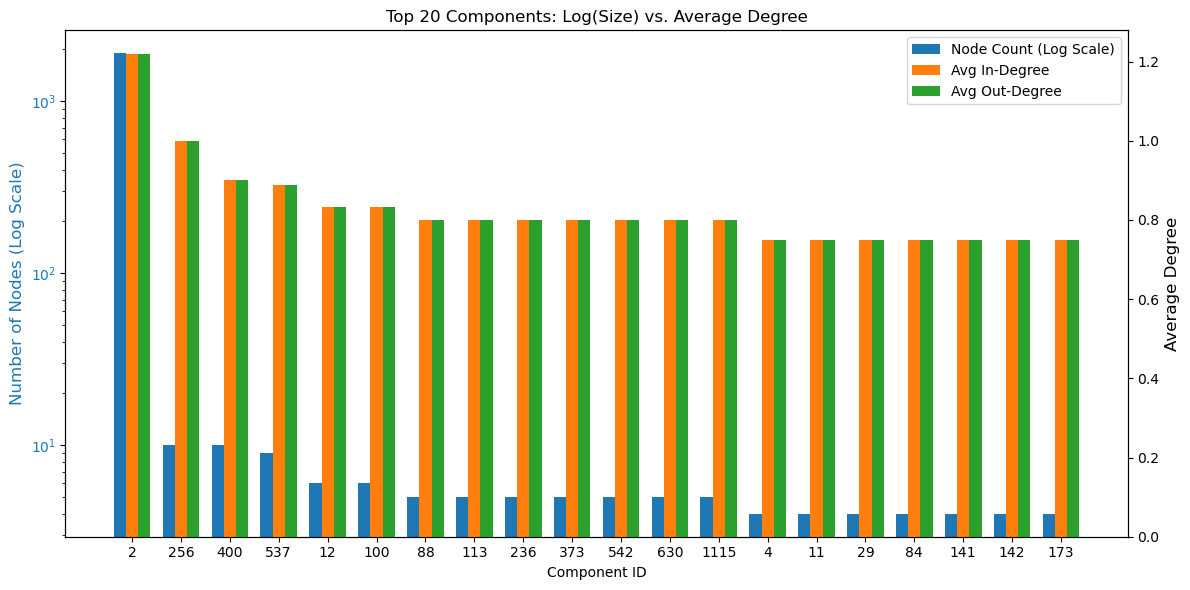

In [75]:
plot_top_largest_components(G, num_components=20)

### Getting the largest component

In [77]:
# Identify the nodes in the largest component
largest_cc_nodes = max(nx.weakly_connected_components(G), key=len)

# Create the subgraph and copy it
largest_component = G.subgraph(largest_cc_nodes).copy()

# Write to GEXF
nx.write_gexf(largest_component, "../data/largest_component.gexf")

nodes = largest_component.number_of_nodes()
edges = largest_component.number_of_edges()
density = edges / (nodes ** 2)
avg_degree = sum(dict(largest_component.out_degree()).values()) / nodes

print(f"Original Graph Nodes: {G.number_of_nodes()}")
print(f"Largest Component Nodes: {nodes}")
print(f"Largest Component Edges: {edges}")
print(f"Largest Component Density: {density}")
print(f"Largest Component Average Degree: {avg_degree}")

# Calculate shortest path lengths between all reachable pairs
path_lengths = []

# nx.shortest_path_length returns an iterator of (source, dictionary_of_lengths)
for source, targets in nx.shortest_path_length(largest_component):
    for target, length in targets.items():
        if source != target: # Exclude distance to self (0)
            path_lengths.append(length)

if len(path_lengths) > 0:
    avg_path_length = sum(path_lengths) / len(path_lengths)
    print(f"Average length of existing paths: {avg_path_length}")
else:
    print("No paths exist in the graph.")


Original Graph Nodes: 5159
Largest Component Nodes: 1899
Largest Component Edges: 2313
Largest Component Density: 0.0006413951967735575
Largest Component Average Degree: 1.2180094786729858
Average length of existing paths: 2.4960758332483945


<center>
<img src="../images/largest_component.png" alt="Largest Component" width="600"/>
</center>

### Plotting animals with high degree nodes

  Node ID                   Name  Degree        Category
0    2566  Butterflies and Moths      47         Insecta
1      72      Ray-finned Fishes      22  Actinopterygii
2    1560                  Flies      21         Insecta
  Node ID                   Name  Degree Category
0     438       Great Blue Heron      46     Aves
1     381      Western Honey Bee      34  Insecta
2    2566  Butterflies and Moths      23  Insecta


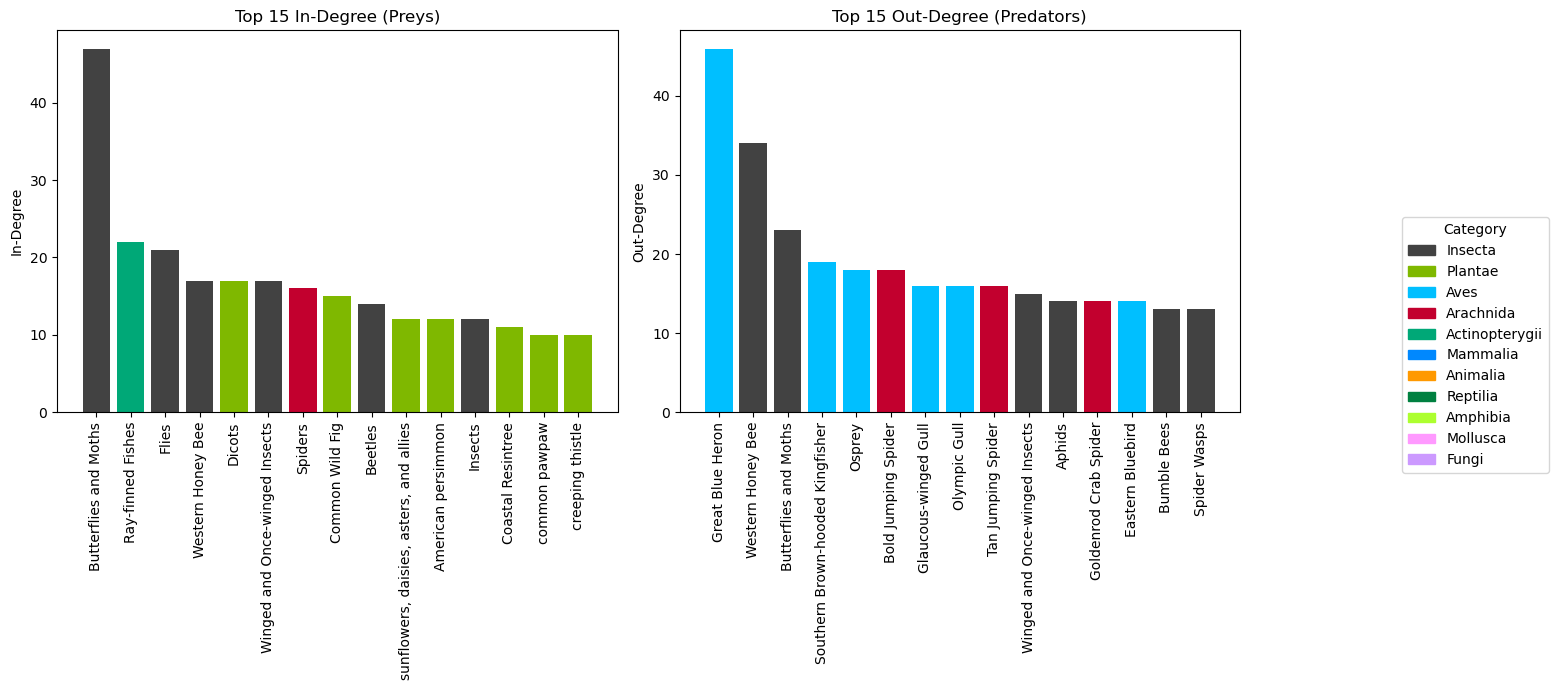

In [46]:
plot_top_degree_comparison(G, top_n=15)

### Getting network with high degree nodes

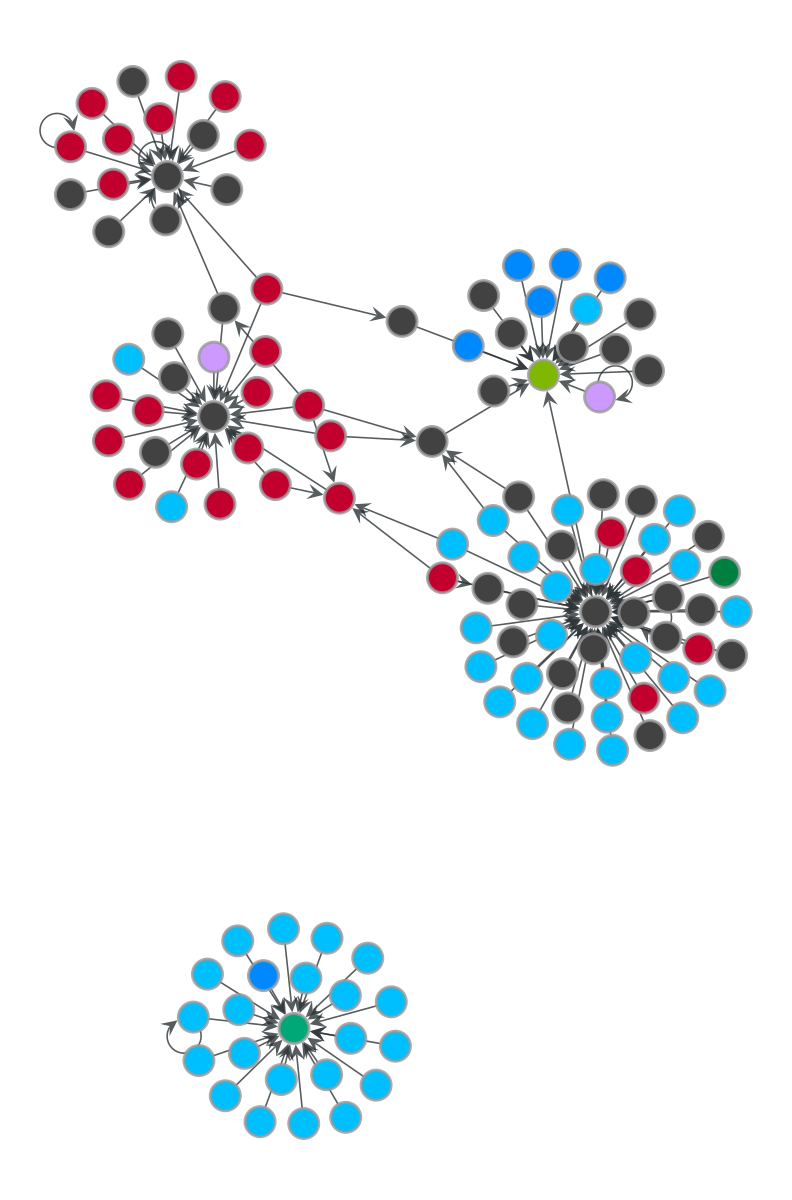

In [48]:
# Get top in-degree nodes
df_in_top, colors_in = get_dataframe_top_degree_by_animal(G, top_n=5, degree_type='in')

# Extract their neighborhood subgraph
G_top5_in = extract_neighborhood_subgraph(df_in_top, G, degree_type='in')

# Plot the subnetwork
plot_subnetwork(G_top5_in, category_colors, degree_type='in')


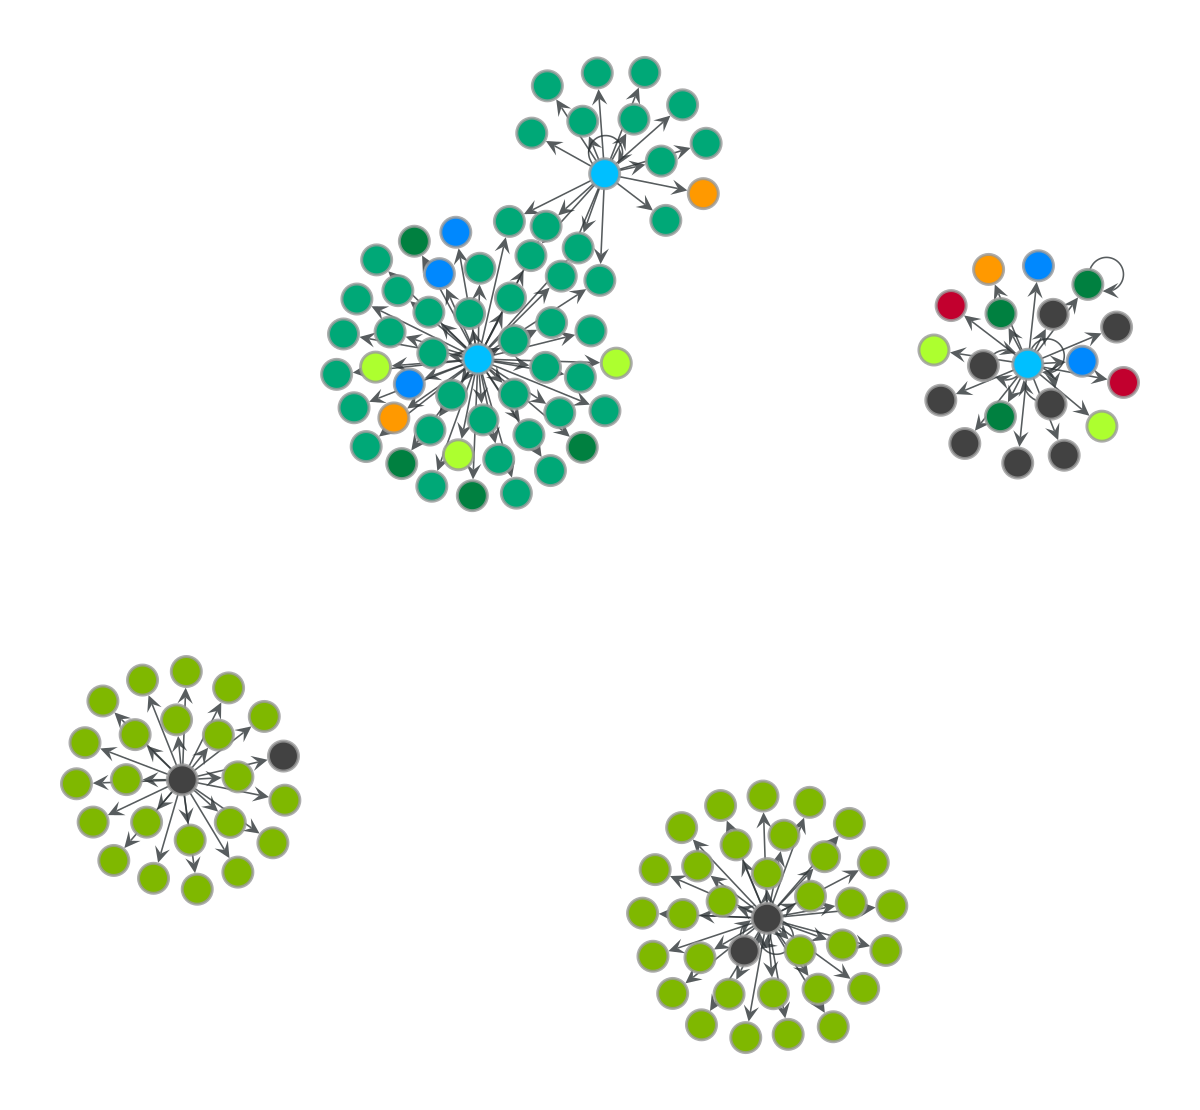

In [18]:
# Get top in-degree nodes
df_out_top, colors_out = get_dataframe_top_degree_by_animal(G, top_n=5, degree_type='out')

# Extract their neighborhood subgraph
G_top5_out = extract_neighborhood_subgraph(df_out_top, G, degree_type='out')

# Draw the subgraph
plot_subnetwork(G_top5_out, category_colors, degree_type='out')

### Motifs extraction (Community Modules)

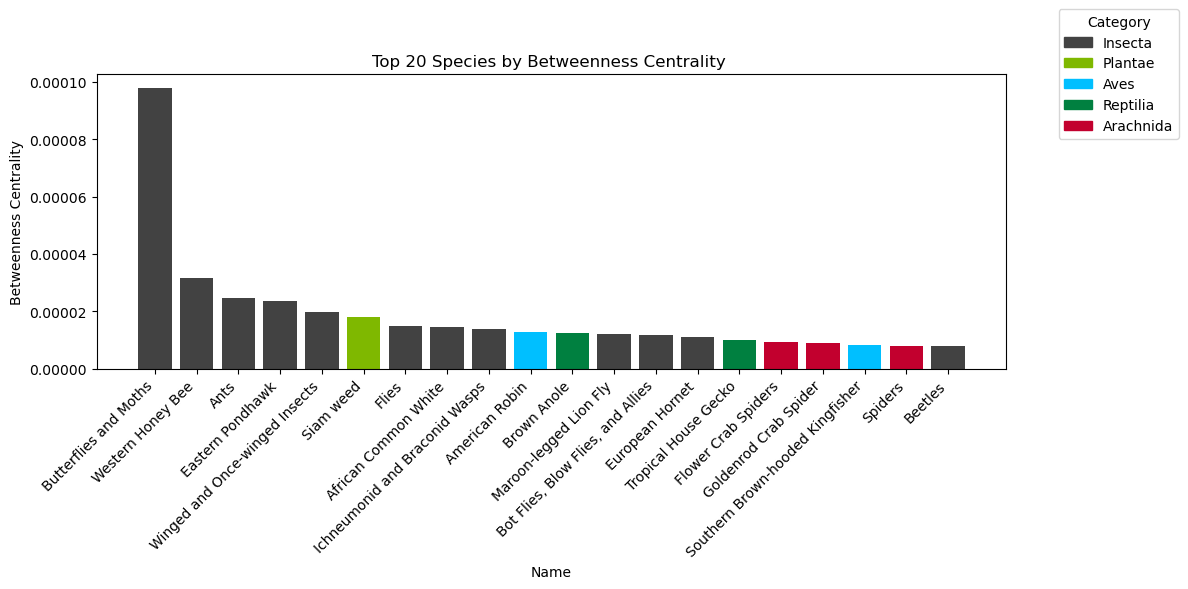

In [68]:
plot_betweenness_by_animal(G)

<center>
<img src="../images/community_modules.png">
</center>

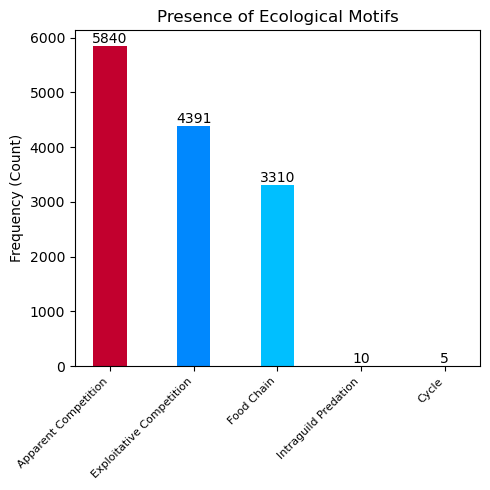

In [20]:
df_motifs = plot_network_motifs(G)

In [69]:
def analyze_critical_chain_links(graph):
    """
    Identifies A -> B -> C chains where A is an 'Obligate Predator' of B
    (meaning A only eats B).
    """
    # 1. Dictionary to count how often a node is the Critical 'B'
    critical_counts = {node: 0 for node in graph.nodes()}
    
    # Store specific vulnerability pairs for reference (Who will die if B dies?)
    vulnerable_predators = {node: [] for node in graph.nodes()}

    # 2. Iterate through all potential 'B' nodes
    for b in graph.nodes():
        
        # 'B' must have a successor 'C' (B -> C) for this to be a chain
        if graph.out_degree(b) == 0:
            continue
            
        # Look at everyone who eats 'B' (Predecessors 'A')
        # A -> B
        predators_of_b = list(graph.predecessors(b))
        
        for a in predators_of_b:
            # CHECK: Does 'A' eat anyone else?
            # We want cases where A's ONLY food source is B
            if graph.out_degree(a) == 1:
                # This is a critical link!
                critical_counts[b] += 1
                
                # Record that 'A' relies entirely on 'B'
                a_name = graph.nodes[a].get('common_name', str(a))
                vulnerable_predators[b].append(a_name)

    # 3. Format the Data
    data = []
    for node, count in critical_counts.items():
        if count > 0:
            name = graph.nodes[node].get('common_name', str(node))
            cat = graph.nodes[node].get('category', 'Unknown')
            
            # Count distinct predators that would starve
            dependent_predators = len(vulnerable_predators[node])
            
            data.append({
                'Node ID': node,
                'Name': name,
                'Category': cat,
                'Critical Link Count': count,
                'Dependent Predators': vulnerable_predators[node] # List of names
            })
            
    # Sort by how many predators rely on this node
    df = pd.DataFrame(data).sort_values('Critical Link Count', ascending=False)
    
    return df

In [72]:
def plot_critical_nodes(df):
    # Take top 15 for readability
    top_df = df.head(15).sort_values('Critical Link Count', ascending=True)
    
    plt.figure(figsize=(8, 5))
    
    # Color bars by category
    bar_colors = [category_colors.get(c, '#d3d3d3') for c in top_df['Category']]
    
    bars = plt.barh(top_df['Name'], top_df['Critical Link Count'], color=bar_colors)
    
    plt.xlabel("Number of Predators (Obligated)")
    plt.title("Critical Species")
    
    # Add grid
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    
    # Label values
    for i, v in enumerate(top_df['Critical Link Count']):
        plt.text(v + 0.1, i, str(v), va='center', fontweight='bold')
        
    plt.tight_layout()
    plt.show()

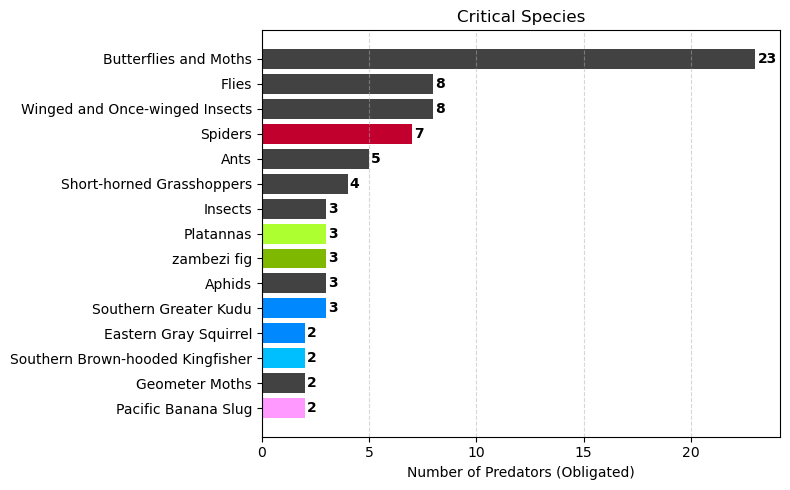

In [73]:
df_critical = analyze_critical_chain_links(G)
plot_critical_nodes(df_critical)


In [24]:
def plot_dynamics_by_iteration(df):
    """
    Plots the network collapse over time (Iterations).
    X-Axis:  Iteration Step
    Y1-Axis: Fraction of nodes surviving (Robustness Proxy)
    Y2-Axis: Connectance of the remaining network
    """
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    
    # --- X-Axis: Iteration ---
    x = df['Iteration']
    
    # --- Y1: Robustness (Survival Fraction) ---
    color = 'tab:blue'
    ax1.set_xlabel('Iteration (Step #)', fontsize=12)
    ax1.set_ylabel('Robustness (Fraction Surviving)', color=color, fontsize=12, fontweight='bold')
    
    # Plot Survival
    line1 = ax1.plot(x, df['Fraction_Surviving'], color=color, linewidth=2.5, label='Robustness (Survival)')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim(0, 1.05)
    ax1.grid(True, axis='x', linestyle='--', alpha=0.5)

    # --- Y2: Connectance ---
    ax2 = ax1.twinx()  # Create a second Y-axis that shares the same X
    color = 'tab:red'
    ax2.set_ylabel('Connectance (L/N²)', color=color, fontsize=12, fontweight='bold')
    
    # Plot Connectance
    line2 = ax2.plot(x, df['Connectance'], color=color, linestyle='--', linewidth=2, label='Connectance')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Optional: Highlight the "Breaking Point"
    # Find where the biggest drop happened?
    # Or just keep it clean.
    
    # Combine Legends
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='center right')
    
    plt.title("Network Collapse Trajectory: Robustness vs. Connectance", fontsize=14)
    plt.tight_layout()
    plt.show()

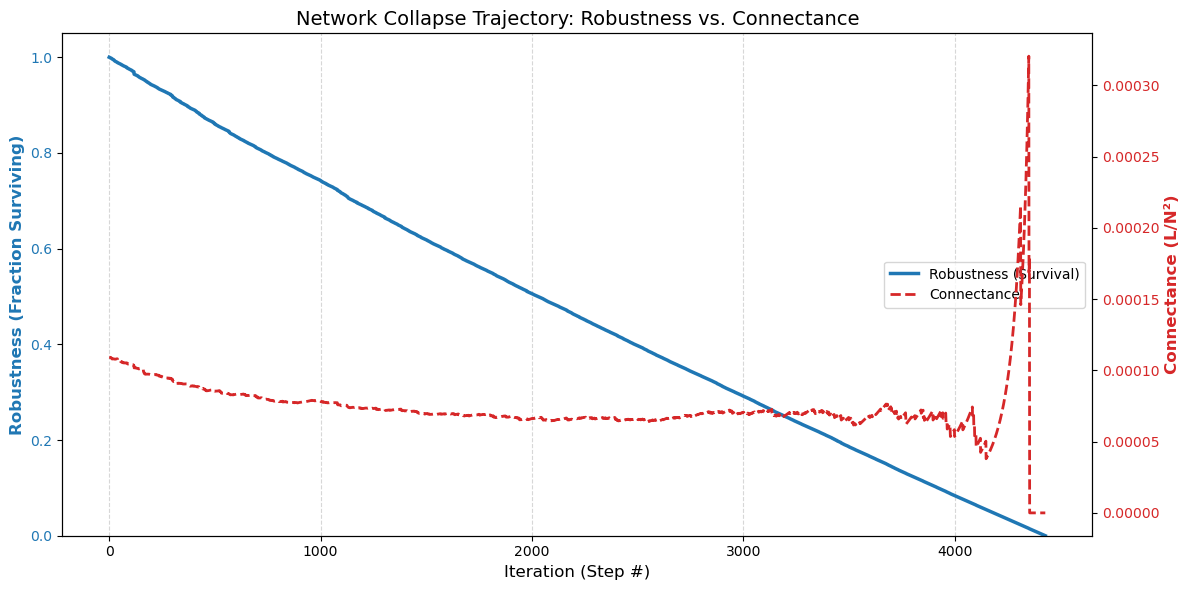

In [29]:
# --- USAGE ---
# 1. Run the simulation
df_results = simulate_attack(G)

# 2. Check the data (optional)
# print(df_results.head())

# 3. Plot
plot_dynamics_by_iteration(df_results)


Found ID: 2566 for name 'Butterflies and Moths'


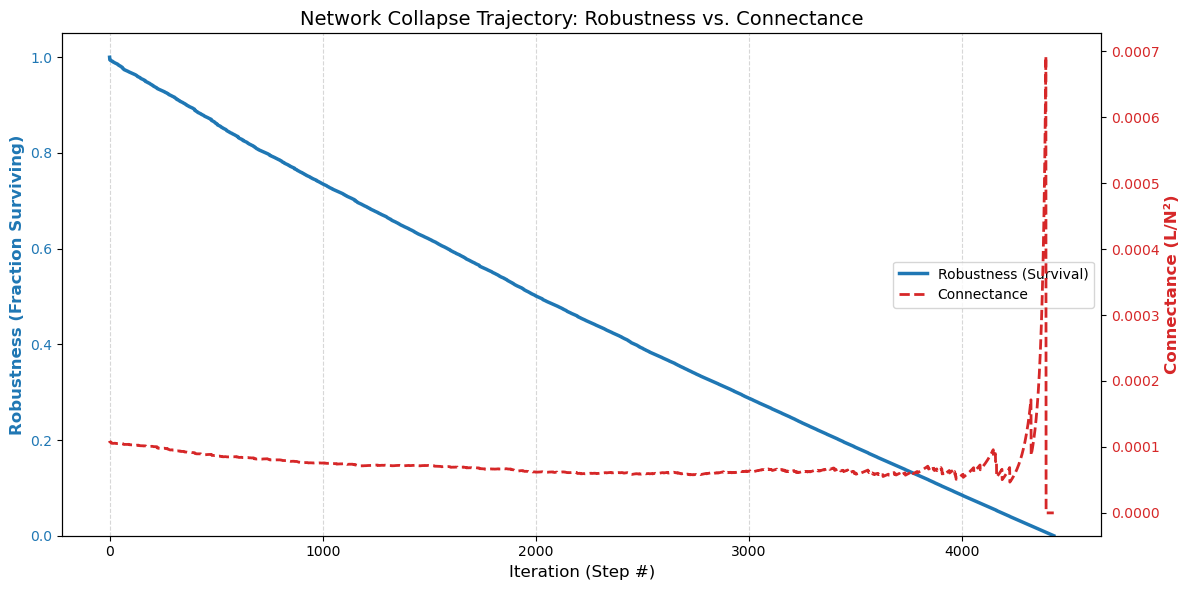

In [28]:
# The name you are looking for
target_name = "Butterflies and Moths"

# Search for the Node ID
# This looks at every node (n) and its data (d)
# It returns the first node 'n' where the 'common_name' matches
target_node_id = next((n for n, d in G.nodes(data=True) 
                       if d.get('common_name') == target_name), None)

# Check if we found it
if target_node_id is not None:
    print(f"Found ID: {target_node_id} for name '{target_name}'")
    
    # --- PASS IT TO THE FUNCTION ---
    df_result = simulate_attack(G, first_target=target_node_id)
    
    # Plot the result
    plot_dynamics_by_iteration(df_result)
    
else:
    print(f"Error: No species found with the name '{target_name}'")

Found ID: 2566 for name 'Butterflies and Moths'


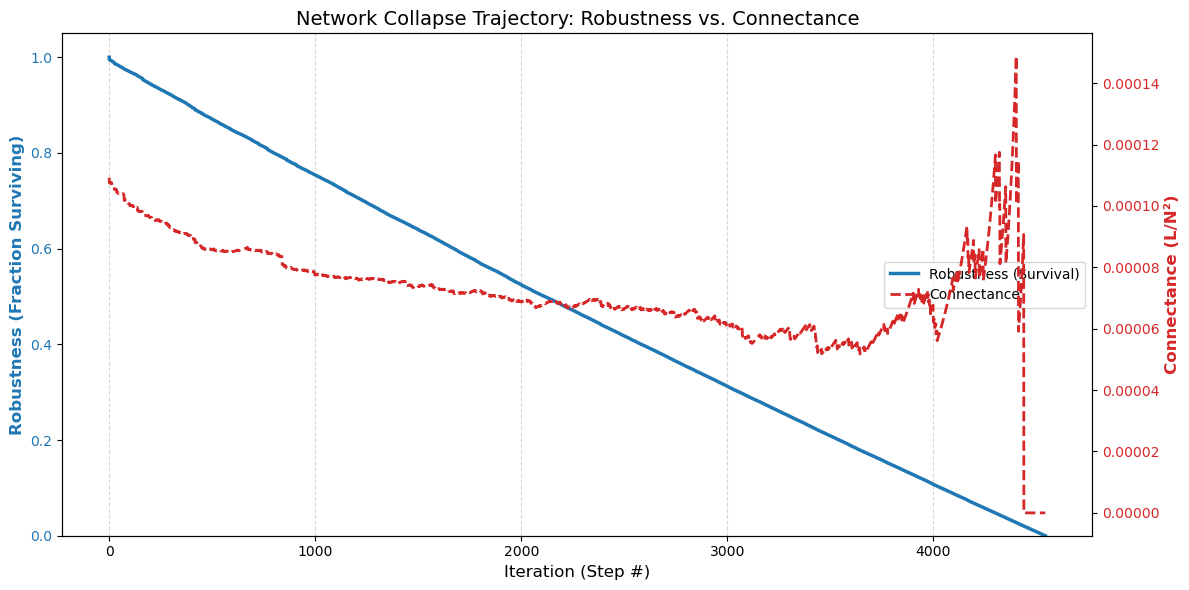

In [32]:
# The name you are looking for
target_name = "Butterflies and Moths"

# Search for the Node ID
# This looks at every node (n) and its data (d)
# It returns the first node 'n' where the 'common_name' matches
target_node_id = next((n for n, d in G.nodes(data=True) 
                       if d.get('common_name') == target_name), None)

# Check if we found it
if target_node_id is not None:
    print(f"Found ID: {target_node_id} for name '{target_name}'")
    
    # --- PASS IT TO THE FUNCTION ---
    df_result = simulate_attack(G, first_target=target_node_id, mode="expanded")
    
    # Plot the result
    plot_dynamics_by_iteration(df_result)
    
else:
    print(f"Error: No species found with the name '{target_name}'")